#**The Prophet Forecasting Model / Time Series Forecasting**


##**What is this?**

The Prophet is a time series forecasting model designed to handle the *common features* of business time series.

So, we could define such characteristics as:
- hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- strong multiple “human-scale” seasonalities: day of week and time of year
- important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
- a reasonable number of missing observations or large outliers
- historical trend changes, for instance due to product launches or logging changes
- trends that are non-linear growth curves, where a trend hits a natural limit or saturates

##**How it works?**

At its core, the Prophet procedure is *an additive regression model* with four main components:
1. A piecewise linear or logistic growth curve trend. Prophet automatically 
detects changes in trends by selecting changepoints from the data.
2. A yearly seasonal component modeled using Fourier series.
3. A weekly seasonal component using dummy variables.
4. A user-provided list of important holidays.

###**The Math behind the Prophecy**
Trying to describe the model throughout mathematical language, we can get a formula: \
\
$$y(t)=g(t)+s(t)+h(t)+\varepsilon_{t}$$
\
where $g(t)$ is the trend function which models non-periodic changes in the value of the time  series;\
$s(t)$  represents  periodic  changes (e.g.,  weekly  and  yearly  seasonality); \
$h(t)$ represents the effects of holidays which occur on potentially irregular schedules overone or more days;\
$\varepsilon_{t}$ represents any idiosyncratic changes which are not accommodated  by  the  model.

###**Coding is Magic**

Prophet is designed to perform the majority of necessary adjustments automatically, but allows for some customizations. 

Essentially, to perform a model fitting and make a forecast one has to properly label the data, create a model as an instance of a built-in `Prophet()` class and call fitting and predicting functions. It is way less work than is needed for, for example, a `SARIMAX` implementation, if a process is non-stationary and needs severe adjustments. Prophet also provides some visualization tools to examine model’s performance. 

Let’s proceed with a coding example.


##**Code tutorial**

**План части с кодом**:
1. Описание синтаксиса: объясняем как фитить модель на примере; описываем основные функции, а затем рассказываем, как кастомизировать модель, какие дополнительные параметры можно указать 
2. Строим интервальные прогнозы(??)
3. Оцениваем модель: удаляем часть данных из исходного датафрейма, прогнозируем их с помощью модели и сравниваем с оригинальными; считаем MSE
4. Сравниваем модель с моделью SARIMAX, смотрим, какая дает более точное предсказание
5. Мы не можем проверить устойчивость коэффицентов с помощью скользящего окна, но мы можем проверить, насколько увеличивается качество предсказаний при увеличении данных для фита (делаем что-то вроде global moving calibration-validation) 



**Fitting a simple model using Prophet**

Prophet can be installed simply via `pip`.

In [ ]:
pip install fbprophet #downloading a library

In [ ]:
import pandas as pd       #importing libraries for working with dataframes and the fbprophet itself
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [ ]:
from google.colab import files #loading the file with data into colab
uploaded = files.upload()

Saving GlobalLandTemperaturesByCountry.csv to GlobalLandTemperaturesByCountry.csv


In this tutorial we will work with a dataset containing temperature measurements in a variety of countries, specifically with a subset containing observations taken in Russia.

In [ ]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', sep=",",index_col='dt', parse_dates=True) #loading the dataset
df.head()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland
1744-02-01,NaN,NaN,Åland
1744-03-01,NaN,NaN,Åland


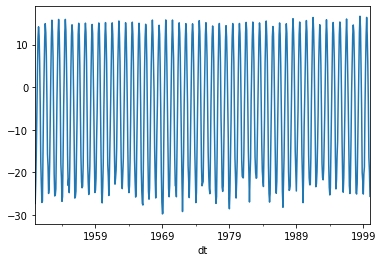

In [ ]:
df_Russia = df.loc[df['Country'] == 'Russia']     #choosing rows with Russia and visualising the data 
df_Russia.columns = ['y', 'AverageTemperatureUncertainty', 'Country']
fig, ax = plt.subplots()
df_Russia['y']['1950-1-1':'2000-1-1'].plot(ax=ax)
plt.show()

Prophet requires data to be stored as a `pandas DataFrame()` object, the first column being the date (named ‘ds’, containing `date-times`), the second being observed responses (named ‘y’).

In [ ]:
df_Russia.insert(3,'ds', df_Russia.index, True)  #adding another columns with datas because prophet requires to have datas as a separate columns
df_Russia.head()

,y,AverageTemperatureUncertainty,Country,ds
dt,,,,
1812-01-01,-27.114,4.336,Russia,1812-01-01
1812-02-01,-25.644,4.394,Russia,1812-02-01
1812-03-01,-19.108,4.171,Russia,1812-03-01
1812-04-01,-7.605,4.286,Russia,1812-04-01
1812-05-01,2.296,3.594,Russia,1812-05-01


To make a Prophet forecast, first create a model as a `Prophet()` object; it takes additional arguments for manual tuning, such as growth type, seasonality, trend change points etc., but by default the model will try to figure out all necessary features by itself.

Apply a `.fit()` function passing it the data and the model is ready to go.


In [ ]:
m = Prophet()   #fitting the model
m.fit(df_Russia[['ds','y']]['1910-1-1':'2013-9-1'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


To perform a prediction, create a data frame of future dates to predict. It can be accomplished with Prophet’s `make_future_dataframe()` method; it takes the amount of points to generate and their frequency as arguments. In this example, 48 points are generated with monthly frequency, which is equivalent to 4 years.

To make a forecast, apply a `.predict()` function to the model and pass it the future data frame.

Prophet has a few visualization tools. First, `.plot()` provides an overview of the forecast (points represent observations):


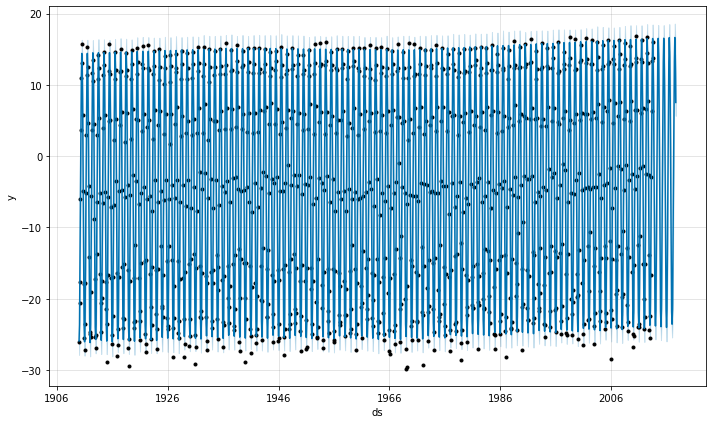

In [ ]:
future = m.make_future_dataframe(periods=48, freq='MS') #making predictions for 2 years (48 months)
future.tail()
fcst = m.predict(future)
fig = m.plot(fcst)

Method `.plot_components()` plots the features separately: trend, seasonality, abnormal dates if provided (such as holidays or Black Fridays)

Those can be provided as arguments of the model’s `Prophet()` object; customizing possibilities include linear/logistic trend setting, change points management, seasonality management, holidays specification and uncertainty estimation tuning.


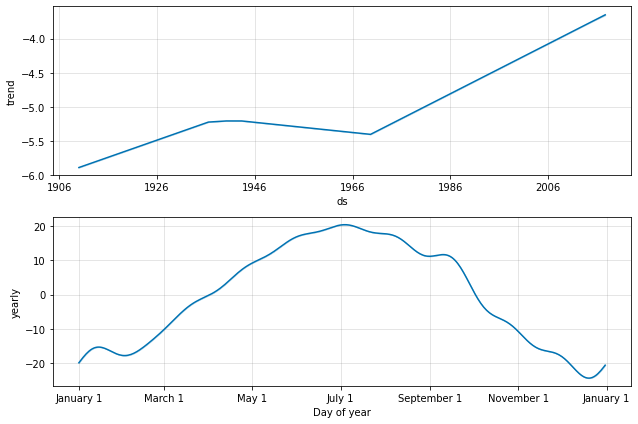

In [ ]:
fig2 = m.plot_components(fcst) #

**Оценка качества модели на прошлых данных и с другой моделью**

Let's check the quality of our model. To do this, we will temporarily delete the data from 01.10.2000 to 01.09.2013 and predict it using our model. Then we will calculate the MSE(?) to check how close the predictions are. 
In the code below we fit the model and visualise the results.
 

Fit the model as before, base it on data with excluded 2000-2013 time period.

In [ ]:
quality_test_model = Prophet()    #fitting the model to the data without last 13 years
quality_test_model.fit(df_Russia[['ds','y']]['1950-1-1':'2000-9-1'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Construct a data frame for future points, including the test data, and make a forecast.

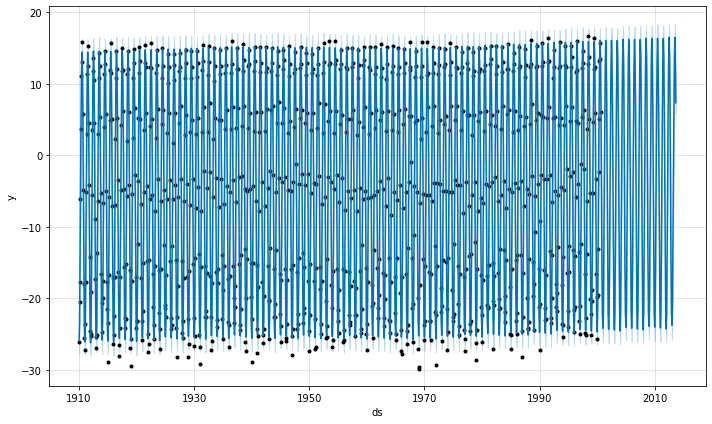

In [ ]:
future = quality_test_model.make_future_dataframe(periods=156, freq='MS') #making predictions for 2000-2013
fcst = quality_test_model.predict(future)
fig = quality_test_model.plot(fcst) #plotting the data with predictions

To calculate accuracy measures, add the forecasted responses to the true responses data frame.

In [ ]:
#joining the true and predicted data
forecasted_df = fcst.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_Russia.set_index('ds')) 

In [ ]:
#writting a function for visual comparison of the results

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

def show_forecast(forecasted_df, num_predictions, num_values):
    # forecast
    forecast = go.Scatter(
        name='Prediction',
        x=forecasted_df.tail(num_predictions).index,
        y=forecasted_df.tail(num_predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # lower bond of prediction interval
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=forecasted_df.tail(num_predictions).index,
        y=forecasted_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="blue"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

  
    # lower part of prediction interval
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=forecasted_df.tail(num_predictions).index,
        y=forecasted_df.tail(num_predictions).yhat_lower,
        marker=dict(color="green"),
        line=dict(width=0),
        mode='lines')

    # true values
    fact = go.Scatter(
        name='Fact',
        x=forecasted_df.tail(num_values).index,
        y=forecasted_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, fact, forecast]

    layout = go.Layout(
        yaxis=dict(title='Средняя температура'),
        showlegend = True,
        width=900, height=500)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(forecasted_df, 156, 200)

In the graph above we plotted the tails of real and predicted data. We can see that prophen model follows the true observations closely. 
Now let's check the precision using MAE - mean absolute error and MAPE - mean absolute percent error.

*calculating MAE, MAPE and making coclusions*

**Comaprison with SARIMAX**

We also want to know whether our model is good in comparison with others. We want to test it against the SARIMAX model.

Steps:
1. Fit the SARIMAX model on the dataframe without last 13 years.
2. Predict the last 13 years using SARIMAX
3. Compare the efficiency using MAE and MAPE.